# IDS-IPS with Deep Learning

Our goal is to build a proof-of-concept model that mimics an IDS-IPS system by predicting whether a stream of network data is malicious or benign. Common IDS-IPS systems use signature-based detection that flags previously-identified malicious network activities. While there are anomaly-based IDS-IPS systems, they often use DBSCAN (Density-Based Spatial Clustering of Applications with Noise) or Gaussian Mixture Models to identify outliers. In this notebook, I will attempt to build a DNN that identifies anomalies in network activity and perform classification. In addition, I will also build an autoencoder network, PCA, DBSCAN, K-Means Clustering and a Gaussian Mixture Model for benchmark purpsoes.

The dataset we're using is from ISCX 2017. 

> CICIDS2017 dataset contains benign and the most up-to-date common attacks, which resembles the true real-world data (PCAPs). It also includes the results of the network traffic analysis using CICFlowMeter with labeled flows based on the time stamp, source and destination IPs, source and destination ports, protocols and attack (CSV files).

# EDA

In [115]:
# Essentials
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

import os
pd.set_option("display.precision", 2)

# MLxtend
from mlxtend.feature_selection import ColumnSelector
# Models
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure, accuracy_score

# Misc
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

In [6]:
# Here, we take a look at how many CSV files we have
print(os.listdir('./data'))

['Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 'Monday-WorkingHours.pcap_ISCX.csv', 'Friday-WorkingHours-Morning.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 'Tuesday-WorkingHours.pcap_ISCX.csv', 'Wednesday-workingHours.pcap_ISCX.csv', 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv']


First, let's load in the dataset and have a look at the raw data. Since we have multiple csv files, I'll load them all at once and concatenate them into one giant dataframe

In [7]:
df_list = []
for filename in os.listdir('./data'):
    df = pd.read_csv(os.path.join('./data',filename), index_col=None)
    df_list.append(df)
df = pd.concat(df_list[:2], axis=0, ignore_index=True)

df.shape

(818520, 79)

At a quick glance, we have 2830743 entries, 78 features and 1 label for the class of the network data. Let's take a closer look at the data. Here, we can see that there are a lot of pre-calculated mean, max, min, std.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818520 entries, 0 to 818519
Data columns (total 79 columns):
 Destination Port               818520 non-null int64
 Flow Duration                  818520 non-null int64
 Total Fwd Packets              818520 non-null int64
 Total Backward Packets         818520 non-null int64
Total Length of Fwd Packets     818520 non-null int64
 Total Length of Bwd Packets    818520 non-null int64
 Fwd Packet Length Max          818520 non-null int64
 Fwd Packet Length Min          818520 non-null int64
 Fwd Packet Length Mean         818520 non-null float64
 Fwd Packet Length Std          818520 non-null float64
Bwd Packet Length Max           818520 non-null int64
 Bwd Packet Length Min          818520 non-null int64
 Bwd Packet Length Mean         818520 non-null float64
 Bwd Packet Length Std          818520 non-null float64
Flow Bytes/s                    818438 non-null object
 Flow Packets/s                 818520 non-null object
 Flow IAT Mean 

Before we go any further, let's rename the columns so that we can access our column data easier.

In [9]:
df.rename(columns=lambda x: x.lower().lstrip()
          .rstrip().replace(" ", "_"), inplace=True)
df.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_co

Here, we can see that `Flow Bytes/s`, `Flow Packets/s` and `Labels` are all objects, let's convert the types first

In [10]:
df['flow_bytes/s'] = df['flow_bytes/s'].astype('float64')
df['flow_packets/s'] = df['flow_packets/s'].astype('float64')

As we can see, the data is highly imbalanced. This is actually a huge problem in IDS/IPS models since these imbalanced datasets give rise to a high number of false positives and false negatives. My reasoning would be optimizing the model without overfitting, and allowing more false positives than false negatives.

Better safe than sorry...

In [11]:
df.label.value_counts()

BENIGN          818484
Infiltration        36
Name: label, dtype: int64

Finally, let's visualize some of the features to see if there are any interesting distribution / trends.

In [ ]:
numeric_dtypes = ['int64', 'float64']
numeric = []

# We just want the total instead of the pre-calculated features
for i in df.columns:
    if df[i].dtype in numeric_dtypes:
        if 'mean' in i or 'min' in i or 'max' in i or 'std' in i or 'variance' in i:
            pass
        else:
            numeric.append(i)

# visualising data
f, ax = plt.subplots(ncols=2, nrows=0, figsize=(12,12))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)

for i, feature in enumerate(list(df[numeric]), 1):
    if i == 10:
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='label', hue='label', palette='Blues', data=df)
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('Label', size=15, labelpad=12.5)
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()
        

Last but not least, a quick look at the correlation between features.

In [ ]:
correlation = df.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(correlation, vmax=0.9, cmap="Blues", square=True)

## Feature Engineering

In [12]:
# Finding missing values
def percent_missing(df_cols):
    dict_x = {}
    for i in range(0,len(df_cols)):
        dict_x.update({df_cols[i]: round(df[df_cols[i]].isnull().mean()*100,2)})
    return dict_x

missing = percent_missing(df.drop(['label'], axis=1).columns)
df_miss = sorted(missing.items(), key=lambda kv: kv[1], reverse=True)
print('Percent of missing data')
print(df_miss[0:10])

Percent of missing data
[('flow_bytes/s', 0.01), ('destination_port', 0.0), ('flow_duration', 0.0), ('total_fwd_packets', 0.0), ('total_backward_packets', 0.0), ('total_length_of_fwd_packets', 0.0), ('total_length_of_bwd_packets', 0.0), ('fwd_packet_length_max', 0.0), ('fwd_packet_length_min', 0.0), ('fwd_packet_length_mean', 0.0)]


In [81]:
# find all infinite or -infinite values
df = df.replace([np.inf, -np.inf], np.nan)
# fill missing values with mean column values
df.dropna(inplace=True)
# count the number of NaN values in each column
print(np.any(pd.isnull(df))) # Should be False
print(np.all(np.isfinite(df))) # Should be True

False
True


In [82]:
df.shape

(817232, 79)

Now that all missing values have been dropped, we can procede to encode the categorical labels.

In [15]:
# For categorical labels, one hot encode
encoder = LabelEncoder()
categorical_labels = (encoder.fit_transform(df.label))
print({i:label for i,label in enumerate(encoder.classes_)})
df = pd.concat([df.drop(['label'], 1),
          pd.DataFrame({'label': categorical_labels})], axis=1).reindex()
df.head()

{0: 'BENIGN', 1: 'Infiltration'}


,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,22.0,1.66e+02,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.0,0.00e+00,0.00e+00,0.00e+00,0.0,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.0
1,60148.0,8.30e+01,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.0,0.00e+00,0.00e+00,0.00e+00,0.0,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.0
2,123.0,9.99e+04,1.0,1.0,48.0,48.0,48.0,48.0,48.0,0.0,...,40.0,0.00e+00,0.00e+00,0.00e+00,0.0,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.0
3,123.0,3.70e+04,1.0,1.0,48.0,48.0,48.0,48.0,48.0,0.0,...,32.0,0.00e+00,0.00e+00,0.00e+00,0.0,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.0
4,0.0,1.11e+08,147.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.75e+06,2.12e+06,4.82e+06,95.0,9.46e+06,2.66e+06,1.36e+07,5.70e+06,0.0


In [83]:
numerical_cols = df[[i for i in list(df.columns) if 'label' not in i]]
target_variables = df.label
numerical_cols.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,22.0,1.66e+02,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,32.0,0.00e+00,0.00e+00,0.00e+00,0.0,0.00e+00,0.00e+00,0.00e+00,0.00e+00
1,60148.0,8.30e+01,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,32.0,0.00e+00,0.00e+00,0.00e+00,0.0,0.00e+00,0.00e+00,0.00e+00,0.00e+00
2,123.0,9.99e+04,1.0,1.0,48.0,48.0,48.0,48.0,48.0,0.0,...,0.0,40.0,0.00e+00,0.00e+00,0.00e+00,0.0,0.00e+00,0.00e+00,0.00e+00,0.00e+00
3,123.0,3.70e+04,1.0,1.0,48.0,48.0,48.0,48.0,48.0,0.0,...,0.0,32.0,0.00e+00,0.00e+00,0.00e+00,0.0,0.00e+00,0.00e+00,0.00e+00,0.00e+00
4,0.0,1.11e+08,147.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.75e+06,2.12e+06,4.82e+06,95.0,9.46e+06,2.66e+06,1.36e+07,5.70e+06


In [135]:
cols =[x for x in numerical_cols.columns if 'mean' not in x and 'max' not in x and 'min' not in x and 'std' not in x]
numerical_cols = numerical_cols[cols]
(numerical_cols).shape

(817232, 45)

# Modelling

Now that we've trimmed down the features to 45, we can start fitting them in different models and evaluating their performance.

In [136]:
X_train, X_test, y_train, y_test = train_test_split(numerical_cols,target_variables,test_size=0.2, random_state=42)

## KMeans (anomaly based)

> Note that this is an unsuccessful trial and will be followed up with a PCA decomposition before re-applying kmeans

### Elbow Method for optimizing the K

In [201]:
def eval_kmeans(k, dataset, **kwargs):
    estimator = KMeans(random_state=42, n_clusters=k)
    estimator.fit(dataset)
    return sum(np.min(cdist(numerical_cols, estimator.cluster_centers_, 
                 'euclidean'),axis=1)) / numerical_cols.shape[0] 

range_k = range(5,100,25)
res = {}
for k in range_k:
    res[k] = (eval_kmeans(k, X_train))
    
print(res)

{5: 4977753.900811402, 30: 1360386.6936843288, 55: 763238.4067951451, 80: 614871.5363951206}


Text(0.5, 1.0, 'Percentage variance by. K')

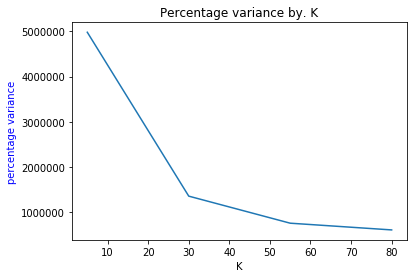

In [138]:
fig, ax = plt.subplots()
ax.plot([c[0] for c in res.items()], [c[1] for c in res.items()])
ax.set_ylabel('percentage variance', color='blue')
plt.xlabel("K")
plt.title("Percentage variance by. K")

From the above graph, a k-value of 55 would be optimal for this anomaly detection problem.

In [141]:
estimator_kmeans = KMeans(n_clusters=55, random_state=42)
estimator_kmeans.fit(numerical_cols)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=55, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

### Describing the clusters

In [145]:
cluster_df = df.assign(cluster_id = estimator_kmeans.labels_).reset_index()
cluster_df.cluster_id.value_counts()

1     480829
25    116610
19     37960
2      23131
53     21843
54     15950
18     13266
29     12238
5       9841
48      8900
39      7953
33      6315
7       5102
37      4673
30      3878
22      3631
16      3504
10      3487
0       3062
21      2766
41      2609
26      2520
12      2432
32      2400
47      2229
42      2158
38      1994
51      1838
45      1813
13      1797
36      1735
31      1701
23      1510
20      1014
14       651
52       528
35       520
27       470
49       448
4        352
44       314
40       271
24       233
8        195
34       159
3        140
15       109
46        57
6         49
28        19
50        13
11         9
9          3
43         2
17         1
Name: cluster_id, dtype: int64

In [173]:
cluster_size = cluster_df.groupby(['cluster_id']).size().reset_index()
cluster_size.columns = ['cluster_id', 'count']
cluster_means = cluster_df.groupby(['cluster_id'], as_index=False).mean()
cluster_summary = pd.merge(cluster_means, cluster_size, on="cluster_id")
cluster_summary = (cluster_summary.drop("index", axis=1).set_index("cluster_id"))
cluster_summary.head(3)

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label,count
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,484.31,6.34e+07,8.91,7.28,756.93,10168.52,209.62,15.59,53.19,65.59,...,699684.02,24703.81,720416.84,680900.78,1.51e+07,1.23e+06,1.63e+07,1.41e+07,0.00e+00,3062
1,12383.55,6.90e+04,2.72,2.10,160.80,795.59,92.83,20.03,34.68,26.79,...,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,3.95e-05,480829
2,311.87,1.16e+08,30.54,33.31,1988.90,32351.42,748.40,0.72,70.09,188.88,...,134365.65,234416.39,786455.63,45630.21,1.17e+07,5.66e+05,1.20e+07,1.04e+07,0.00e+00,23131


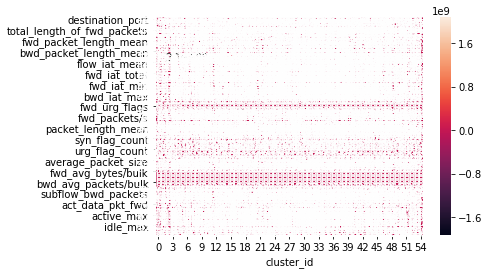

In [176]:
sns.heatmap(cluster_summary.transpose(), annot=True)
plt.show()

> At this meantime, I have no idea how to visualizing the kmeans algorithm with 45 features besides applying PCA and re-applying Kmeans...

## KMeans w/ PCA

In [227]:
pca = PCA(n_components=2)
pca.fit(numerical_cols)
print(pca.explained_variance_ratio_)
pca_data = pca.transform(numerical_cols)

[0.76725569 0.21513631]


As we can see, the first component accounts for about 76.7% meaning of the data whilst the second accounts for about 21.5%. The total information lost would be around 100-98.2 = 1.2%

In [228]:
pca_df = pd.DataFrame(data = pca_data
             , columns = ['principal_component_1', 'principal_component_2'])
pca_df = pd.concat([pca_df,target_variables], axis=1)
pca_df.head(5)

,principal_component_1,principal_component_2,label
0,-1.64e+07,-1.86e+06,0.0
1,-1.64e+07,-1.86e+06,0.0
2,-1.63e+07,-1.86e+06,0.0
3,-1.63e+07,-1.86e+06,0.0
4,1.14e+08,8.13e+04,0.0


Here, we have to drop the nan columns again due to varaible lost in PCA.

In [231]:
pca_df = pca_df.replace([np.inf, -np.inf], np.nan)
pca_df.dropna(axis=0, inplace=True)
print(np.any(pd.isnull(pca_df))) # Should be False
print(np.all(np.isfinite(pca_df))) # Should be True

False
True


An initial look at the data:

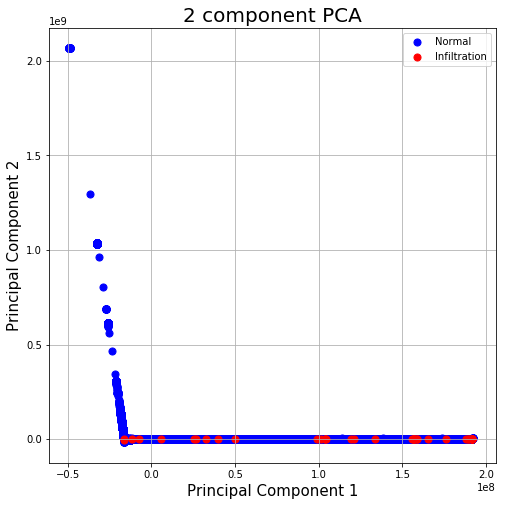

In [232]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['label'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'principal_component_1']
               , pca_df.loc[indicesToKeep, 'principal_component_2']
               , c = color
               , s = 50)
ax.legend(['Normal', 'Infiltration'])
ax.grid()

> We can see that it is rather hard for the kmeans algorithm to assign clusters as there would be too much overlapping and lead to false positives

Here, we will proceed again with the elbow method and try clustering to determine anomalies.

In [234]:
pca_df.shape

(816588, 3)

In [233]:
range_k = range(5,100,25)
res = {}
for k in range_k:
    res[k] = (eval_kmeans(k, pca_df[['principal_component_1', 'principal_component_2']]))
    
print(res)

ValueError: XA and XB must have the same number of columns (i.e. feature dimension.)

## DBSCAN (anomaly based)

In [ ]:
estimator_dbscan = DBSCANCAN(eps=10, min_samples=1000)